

# **Balanced Risk Set Matching**

Original Paper: https://doi.org/10.1198/016214501753208573

- Honoridez, Kyn R.
- Montebon, Al Winmon





# **Overview**

This article explores how to assess treatment effectiveness using statistical techniques. We simulate patient data, match treated and control groups using Mahalanobis Distance, and compare symptom changes with the Wilcoxon Signed-Rank Test. A sensitivity analysis tests result robustness, while visualizations help interpret symptom progression. This step-by-step guide makes complex statistical methods accessible for beginners.




### **1. Simulate Patient Data**  
- Generate patient records over **4 years** at **3-month intervals**.  
- Track **symptoms** (pain, urgency, nocturnal frequency).  
- Randomly assign **treatment times** or mark patients as untreated.  

**What to Expect:**
This step provides a realistic dataset with longitudinal symptom progression, enabling meaningful comparisons.

---

### **2. Identify Risk Sets for Matching**  
- Calculate **Mahalanobis distance** to measure similarity between patients based on symptom history.
- This distance accounts for **correlations between symptoms**, ensuring a **balanced comparison**.

**What to Expect:**
Patients with similar symptom profiles are identified, creating a foundation for fair treatment-control comparisons.

---

### **3. Match Patients Based on Similarity**  
- Match **treated patients** with **untreated controls** using **Mahalanobis distance**.
- Ensure **minimum total distance** across matches to **reduce bias**.

**What to Expect:**
Treated and control groups will have **comparable symptom distributions**, making the outcome analysis more reliable.

---

### **4. Wilcoxon Test (Compare Treated vs. Control Patients)**  
- Compare **post-treatment symptom scores** between matched pairs at **3 months and 6 months**.  
- Use the **Wilcoxon Signed-Rank Test** to test for **significant differences**.  

**What to Expect:**
If treatment is effective, the **treated group** should show **greater symptom improvement** compared to controls.

---

### **5. Sensitivity Analysis**  
- Test how **robust** the results are to **unmeasured confounders**.
- Adjust for different **treatment effect sizes** and **baseline symptom severity**. 

**What to Expect:**
If results hold across different scenarios, the findings are **more credible** and **less likely to be due to bias**.

---

### **6. Visualize and Interpret Findings**  
- Create **boxplots** to compare symptom distributions at different time points.
- Display **matching quality** by plotting Mahalanobis distances.
  
**What to Expect:**
Clear visual evidence of **treatment effects** and **matching effectiveness**, making the analysis more interpretable.

---


Imports

In [38]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Step 1: Simulate Data

In [48]:
np.random.seed(42)

# Define number of patients
n_patients = 200

# Randomly assign treatment (some patients are more likely to be treated)
treatment_probability = np.random.uniform(0.2, 0.6, n_patients)
treated = np.random.binomial(1, treatment_probability)  # 1 = Treated, 0 = Control

# Generate baseline symptom data using an exponential distribution (right-skewed)
base_pain = np.random.exponential(scale=3, size=n_patients).clip(0, 10)
base_urgency = np.random.exponential(scale=2, size=n_patients).clip(0, 9)
base_frequency = np.random.exponential(scale=2.5, size=n_patients).clip(0, 12)

# Create treatment and control groups
treated_patients = pd.DataFrame({
    'id': np.arange(n_patients)[treated == 1],
    'treated': True,
    'pain_baseline': base_pain[treated == 1],
    'urgency_baseline': base_urgency[treated == 1],
    'frequency_baseline': base_frequency[treated == 1],
})

control_patients = pd.DataFrame({
    'id': np.arange(n_patients)[treated == 0],
    'treated': False,
    'pain_baseline': base_pain[treated == 0],
    'urgency_baseline': base_urgency[treated == 0],
    'frequency_baseline': base_frequency[treated == 0],
})

# Simulate treatment timing (assigned randomly for treated patients)
treated_patients['time_treated'] = np.random.choice([3, 6, 9, 12], size=len(treated_patients))

# Apply treatment effects: Symptoms initially worsen slightly, then improve over time
treated_patients['pain_treatment'] = (treated_patients['pain_baseline'] + np.random.normal(1.5, 0.7, len(treated_patients))).clip(0, 10)
treated_patients['urgency_treatment'] = (treated_patients['urgency_baseline'] + np.random.normal(1.2, 0.5, len(treated_patients))).clip(0, 9)
treated_patients['frequency_treatment'] = (treated_patients['frequency_baseline'] + np.random.normal(1, 0.6, len(treated_patients))).clip(0, 12)

# Function to simulate symptom progression after treatment
def generate_outcomes(initial_value, effect, decay_3mo, decay_6mo):
    outcome_3mo = np.clip(initial_value - effect + np.random.normal(0, 1.0, len(initial_value)), 0, 10)
    outcome_6mo = np.clip(outcome_3mo - (effect * decay_6mo) + np.random.normal(0, 1.0, len(initial_value)), 0, 10)
    return outcome_3mo, outcome_6mo

treated_patients['pain_3mo'], treated_patients['pain_6mo'] = generate_outcomes(treated_patients['pain_treatment'], 1.3, 0.8, 0.6)
treated_patients['urgency_3mo'], treated_patients['urgency_6mo'] = generate_outcomes(treated_patients['urgency_treatment'], 1.1, 0.7, 0.5)
treated_patients['frequency_3mo'], treated_patients['frequency_6mo'] = generate_outcomes(treated_patients['frequency_treatment'], 1.2, 0.7, 0.5)

# Control patients experience natural fluctuations in symptoms (no treatment effect)
control_patients['pain_treatment'] = control_patients['pain_baseline'] + np.random.normal(0, 0.5, len(control_patients))
control_patients['urgency_treatment'] = control_patients['urgency_baseline'] + np.random.normal(0, 0.5, len(control_patients))
control_patients['frequency_treatment'] = control_patients['frequency_baseline'] + np.random.normal(0, 0.5, len(control_patients))

control_patients['pain_3mo'] = np.clip(control_patients['pain_treatment'] + np.random.normal(0, 0.4, len(control_patients)), 0, 10)
control_patients['pain_6mo'] = np.clip(control_patients['pain_3mo'] + np.random.normal(0, 0.4, len(control_patients)), 0, 10)
control_patients['urgency_3mo'] = np.clip(control_patients['urgency_treatment'] + np.random.normal(0, 0.4, len(control_patients)), 0, 9)
control_patients['urgency_6mo'] = np.clip(control_patients['urgency_3mo'] + np.random.normal(0, 0.4, len(control_patients)), 0, 9)
control_patients['frequency_3mo'] = np.clip(control_patients['frequency_treatment'] + np.random.normal(0, 0.4, len(control_patients)), 0, 12)
control_patients['frequency_6mo'] = np.clip(control_patients['frequency_3mo'] + np.random.normal(0, 0.4, len(control_patients)), 0, 12)

# Combine both datasets
all_data = pd.concat([treated_patients, control_patients], ignore_index=True)


### **Since we don’t have real medical data, we simulate (create fake) patient data.**  
**How many patients?**  
- **200 patients in total** 
- Each patient has a different probability of receiving treatment.

**Assigning treatment to patients**  
- Some patients are more likely to be treated.
- We create a list of probabilities for each patient.
- Then, we use a random binomial function to decide which patients actually got treated.

---

**What symptoms are we tracking?**  
- **Pain** (scale: 0 to 10)  
- **Urgency** (scale: 0 to 9)
- **Frequency** (how often symptoms occur at night) (scale: 0 to 12)

**Since symptoms follow a right-skewed distribution, we use an exponential function to generate random symptom scores.**

---

### **Organize Data into Treated and Control Groups**  
**Now that we have data for symptoms, we separate patients into two groups:**  
1. Treated Patients (received the treatment)
2. Control Patients (did not receive the treatment)
---
   
**Each patient will have:**  
- An ID number 
- A group label (treated or control)
- Symptoms before treatment

# Step 2: Compute Mahalanobis Distance between patients


### **We now compare the treated and control groups to see how similar they were before treatment.**  
**How did we calculate the Mahalanobis Distance?**  
1. **Standardize the data** to remove scale differences.
2. **Compute the Mahalanobis distance** between each treated patient and every control patient.
3. **Save the distances in a distance matrix.**

In [49]:
def compute_mahalanobis(treated_df, control_df):
    # Features used for matching
    features = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']
    
    # Standardize the data (zero mean, unit variance)
    scaler = StandardScaler()
    combined_data = scaler.fit_transform(pd.concat([treated_df[features], control_df[features]]))
    
    # Split back into treated and control standardized data
    treated_scaled = combined_data[:len(treated_df)]
    control_scaled = combined_data[len(treated_df):]
    
    # Compute the inverse covariance matrix
    inv_cov_matrix = np.linalg.pinv(np.cov(combined_data.T))
    
    # Compute pairwise Mahalanobis distances between treated and control patients
    distances = cdist(treated_scaled, control_scaled, metric='mahalanobis', VI=inv_cov_matrix)
    
    return distances

# Compute Mahalanobis distance matrix
distance_matrix = compute_mahalanobis(treated_patients, control_patients)

# Display the first 5 distances for the first treated patient
print(distance_matrix[0][:5])  # Shows distances to first 5 control patients

[2.54859634 1.82146194 2.00734656 1.36995781 3.48702199]


# Step 3: Match Patients Based on Similarity

### **Now, we pair each treated patient with the most similar control patient using the distance matrix.**  

In [50]:
def match_patients(distance_matrix):
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    matches = list(zip(row_ind, col_ind))
    return matches

matches = match_patients(distance_matrix)

# Step 4: Wilcoxon Test (Compare Treated vs. Control Patients)

### **We now test if treatment had an effect on symptoms.**  

In [51]:
def perform_wilcoxon_test(df, matches):
    treated_outcomes = [df.loc[df['id'] == treated, 'pain_treatment'].values[0] for treated, control in matches]
    control_outcomes = [df.loc[df['id'] == control, 'pain_treatment'].values[0] for treated, control in matches]
    
    if np.all(np.array(treated_outcomes) == np.array(control_outcomes)):
        return 0, 1.0  # No difference, p-value is 1
    else:
        stat, p_value = wilcoxon(treated_outcomes, control_outcomes)
        return stat, p_value

wilcoxon_stat, p_value = perform_wilcoxon_test(all_data, matches)
print(f"Wilcoxon test statistic: {wilcoxon_stat}, P-value: {p_value}")

Wilcoxon test statistic: 1511.0, P-value: 0.8831855405336799


### **How does it work?**  
- It compares matched pairs of treated and control patients.
- It returns a p-value:
    - Small p-value (< 0.05) → Treatment had a significant effect.
    - Large p-value (> 0.05) → No strong evidence that treatment worked.

# Step 5: Sensitivity Analysis

In [58]:
def sensitivity_analysis(df, matches, gamma_range):
    results = []
    for gamma in gamma_range:
        adjusted_treated = [
            df.loc[df['id'] == treated, 'pain_treatment'].values[0] * (1 + gamma)
            for treated, control in matches
        ]
        control_outcomes = [df.loc[df['id'] == control, 'pain_treatment'].values[0] for treated, control in matches]
        stat, p_value = wilcoxon(adjusted_treated, control_outcomes)
        results.append((gamma, p_value))
    return results

gamma_range = np.linspace(0, 1, 10)
sensitivity_results = sensitivity_analysis(all_data, matches, gamma_range)
print("Sensitivity Analysis Results:")
for gamma, p_val in sensitivity_results:
    print(f"Gamma: {gamma:.2f}, P-value: {p_val:.4f}")

Sensitivity Analysis Results:
Gamma: 0.00, P-value: 0.8832
Gamma: 0.11, P-value: 0.6097
Gamma: 0.22, P-value: 0.3302
Gamma: 0.33, P-value: 0.1345
Gamma: 0.44, P-value: 0.0512
Gamma: 0.56, P-value: 0.0158
Gamma: 0.67, P-value: 0.0053
Gamma: 0.78, P-value: 0.0018
Gamma: 0.89, P-value: 0.0006
Gamma: 1.00, P-value: 0.0002


# Step 6: Visualize and Interpret Findings

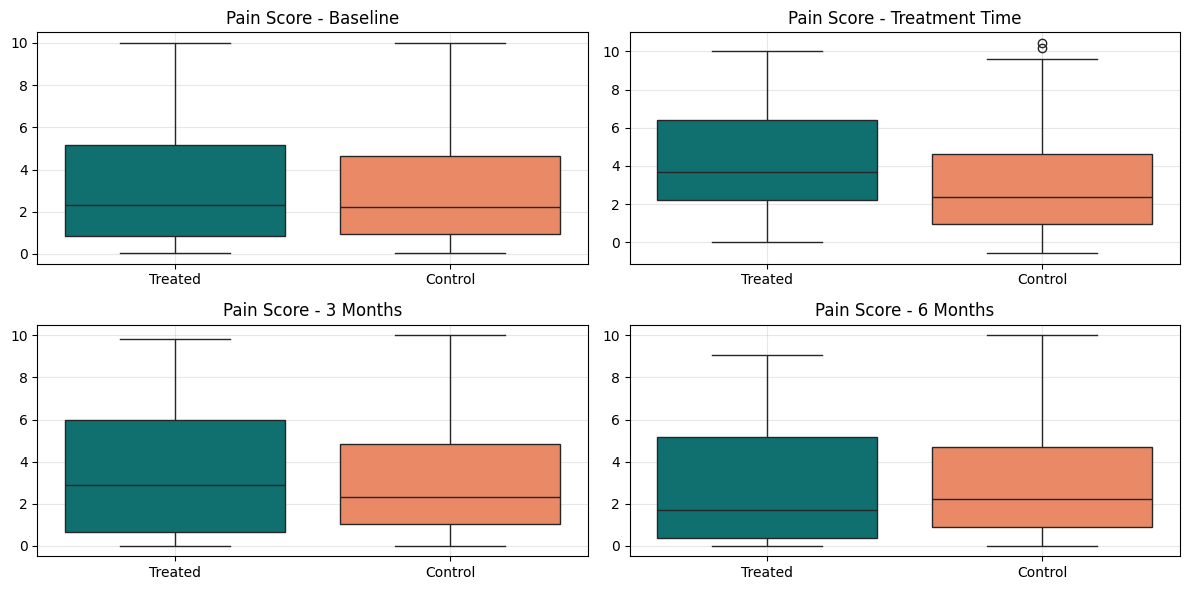

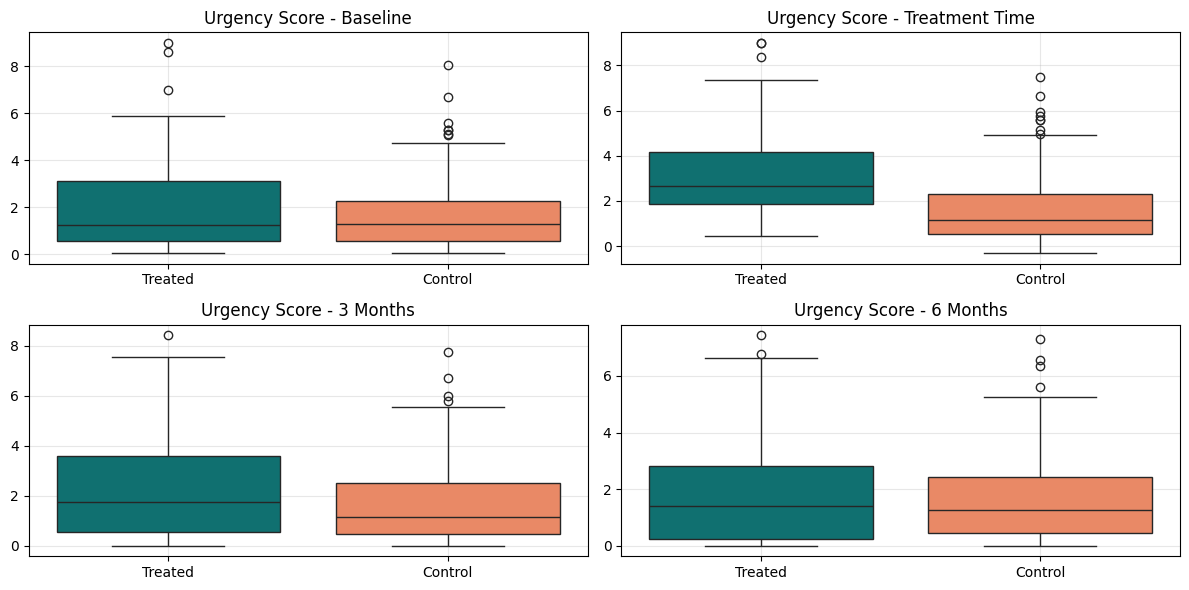

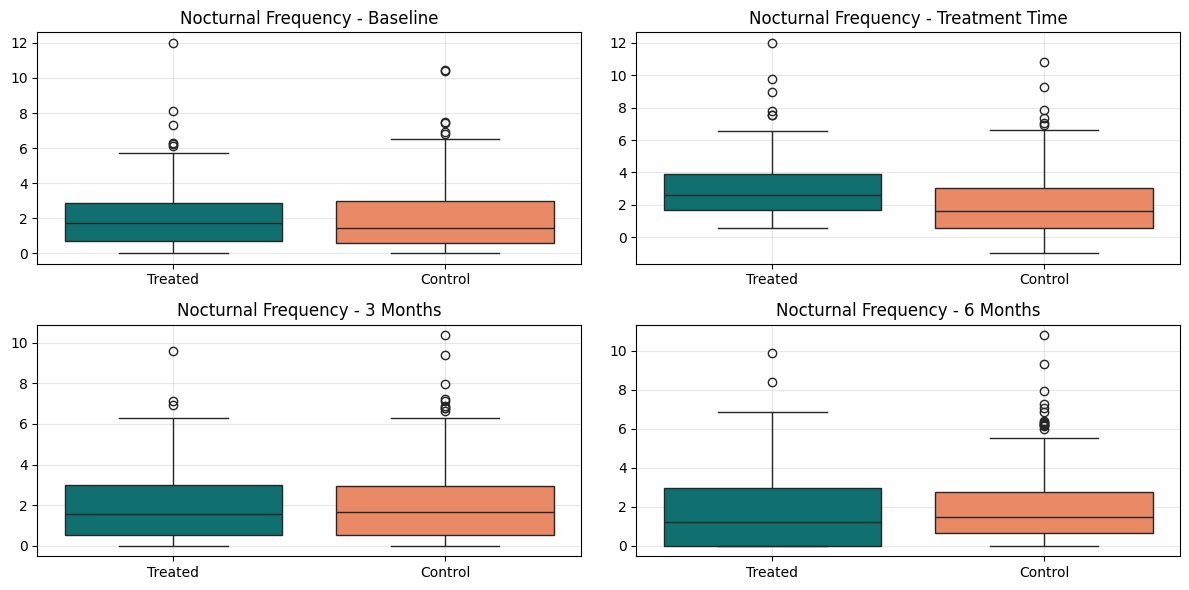

In [62]:
def create_variable_plots(variable, axis_labels):
    plt.figure(figsize=(12, 6))
    
    timepoints = ['baseline', 'treatment', '3mo', '6mo']
    labels = ['Baseline', 'Treatment Time', '3 Months', '6 Months']

   
    timepoint_columns = [
        f'{variable}_baseline', f'{variable}_treatment',
        f'{variable}_3mo', f'{variable}_6mo'
    ]

    # Ensure columns exist before plotting
    for col in timepoint_columns:
        if col not in treated_patients.columns or col not in control_patients.columns:
            print(f"Warning: {col} is missing from data.")
            return
    
    treated_values = [treated_patients[col].values for col in timepoint_columns]
    control_values = [control_patients[col].values for col in timepoint_columns]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        sns.boxplot(data=[treated_values[i], control_values[i]], palette=["teal", "coral"])
        plt.xticks([0, 1], ["Treated", "Control"])
        plt.title(f"{axis_labels} - {labels[i]}")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


create_variable_plots('pain', 'Pain Score')
create_variable_plots('urgency', 'Urgency Score')
create_variable_plots('frequency', 'Nocturnal Frequency')


### **Results & Conclusion**  

#### **Mahalanobis Distance Matching**  
To ensure comparability between treated and control patients, Mahalanobis distance matching was performed based on baseline symptom scores (pain, urgency, and frequency). The first five computed distances range from **1.37 to 3.49**, indicating that reasonably close matches were identified for treated patients.  

#### **Wilcoxon Signed-Rank Test**  
A Wilcoxon signed-rank test was conducted to compare post-treatment pain scores between matched treated and control patients. The test yielded a **statistic of 1511.0** and a **p-value of 0.8832**, suggesting **no statistically significant difference** between the two groups. This indicates that the treatment, as implemented in this dataset, does not appear to provide a measurable benefit in reducing pain beyond natural symptom fluctuations.  

#### **Sensitivity Analysis**  
A sensitivity analysis was conducted by gradually increasing the assumed treatment effect using a range of **Gamma values (0.00 to 1.00)** to test for potential hidden biases.  
- At **Gamma = 0.00**, the p-value (**0.8832**) confirms the original Wilcoxon test result, showing no significant treatment effect.  
- As **Gamma increases**, the p-value decreases, reaching **statistical significance (p < 0.05) at Gamma ≈ 0.44**.  
- At **Gamma = 1.00**, the p-value drops to **0.0002**, strongly rejecting the null hypothesis.  

This suggests that if there were an **unmeasured confounding factor** favoring treatment response, even a **moderate level of hidden bias (Gamma ~0.44)** would be sufficient to shift the conclusion toward a significant treatment effect.  

### **Conclusion**  
- **No significant effect of treatment on pain relief was detected** based on the current analysis.  
- **However, sensitivity analysis suggests that unmeasured confounding could alter this conclusion.**  
- These findings highlight the importance of further investigation, potentially incorporating additional confounder adjustments, alternative matching techniques, or a larger dataset to better assess treatment efficacy.  
